# Convolutional Neural Networks: Application

## 1.0 - TensorFlow Model

In [2]:
import math
import numpy as np
import h5py
import matplotlib.pyplot as plt
import scipy
from PIL import Image
from scipy import ndimage
import tensorflow as tf
from tensorflow.python.framework import ops
from cnn_utils import *

%matplotlib inline
np.random.seed(1)

In [3]:
#Loading data signs
X_train_orig, Y_train_orig, X_test_orig, Y_test_orig, classes = load_dataset()

y = 1


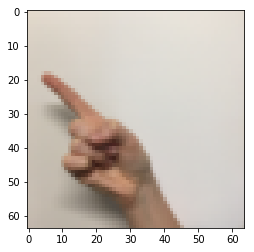

In [5]:
#checking examples
index=7
plt.imshow(X_train_orig[index])
print("y = " + str(np.squeeze(Y_train_orig[:,index])))

In [6]:
X_train = X_train_orig/255
X_test = X_test_orig/255
Y_train = convert_to_one_hot(Y_train_orig,6).T
Y_test = convert_to_one_hot(Y_test_orig,6).T
print("number of training examples = " + str(X_train.shape[0]))
print("number of testing examples = " + str(X_test.shape[0]))
print("X_train shape:" + str(X_train.shape))
print("Y_train shape:" + str(Y_train.shape))
print("X_test shape:" + str(X_test.shape))
print("Y_test.shape:" + str(Y_test.shape))

number of training examples = 1080
number of testing examples = 120
X_train shape:(1080, 64, 64, 3)
Y_train shape:(1080, 6)
X_test shape:(120, 64, 64, 3)
Y_test.shape:(120, 6)


## 1.1 - Create Placeholders

You should not define the number of training examples for the moment. To do so, you could use "None" as the batch size, it will give you the flexibility to choose it later. Hence X should be of dimension **[None, n_H0, n_W0, n_C0]** and Y should be of dimension **[None, n_y]**.  [Hint](https://www.tensorflow.org/api_docs/python/tf/placeholder).

In [7]:
def create_placeholders(n_H0 , n_W0 , n_C0 , n_y):
    X = tf.placeholder(tf.float32 , shape=(None,n_H0,n_W0,n_C0))
    Y = tf.placeholder(tf.float32 , shape=(None,n_y))
    
    return X , Y

In [8]:
X , Y = create_placeholders(64,64,3,6)
print("X = " + str(X))
print("Y = " + str(Y))

X = Tensor("Placeholder:0", shape=(?, 64, 64, 3), dtype=float32)
Y = Tensor("Placeholder_1:0", shape=(?, 6), dtype=float32)


## 1.2 - Initialize parameters

`tf.contrib.layers.xavier_initializer(seed = 0)`

W1 : [4, 4, 3, 8]
W2 : [2, 2, 8, 16]

[More Info](https://www.tensorflow.org/api_docs/python/tf/get_variable).

In [9]:
def initialize_parameters():
    tf.set_random_seed(1)
    W1 = tf.get_variable("W1",[4,4,3,8] , initializer = tf.contrib.layers.xavier_initializer(seed=0))
    W2 = tf.get_variable("W2" ,[2,2,8,16] , initializer = tf.contrib.layers.xavier_initializer(seed=0))
    
    parameters = {
        "W1":W1,
        "W2":W2
    }
    return parameters

In [10]:
tf.reset_default_graph()
with tf.Session() as sess:
    parameters = initialize_parameters()
    init = tf.global_variables_initializer()
    sess.run(init)
    print("W1 = " + str(parameters["W1"].eval()[1,1,1]))
    print("W2 = " + str(parameters["W2"].eval()[1,1,1]))

W1 = [ 0.00131723  0.1417614  -0.04434952  0.09197326  0.14984085 -0.03514394
 -0.06847463  0.05245192]
W2 = [-0.08566415  0.17750949  0.11974221  0.16773748 -0.0830943  -0.08058
 -0.00577033 -0.14643836  0.24162132 -0.05857408 -0.19055021  0.1345228
 -0.22779644 -0.1601823  -0.16117483 -0.10286498]


## 1.3 - Forward propagation

In TensorFlow, there are built-in functions that carry out the convolution steps for you.

- **tf.nn.conv2d(X,W1, strides = [1,s,s,1], padding = 'SAME'):** given an input $X$ and a group of filters $W1$, this function convolves $W1$'s filters on X. The third input ([1,f,f,1]) represents the strides for each dimension of the input (m, n_H_prev, n_W_prev, n_C_prev). You can read the full documentation [here](https://www.tensorflow.org/api_docs/python/tf/nn/conv2d)

- **tf.nn.max_pool(A, ksize = [1,f,f,1], strides = [1,s,s,1], padding = 'SAME'):** given an input A, this function uses a window of size (f, f) and strides of size (s, s) to carry out max pooling over each window. You can read the full documentation [here](https://www.tensorflow.org/api_docs/python/tf/nn/max_pool)

- **tf.nn.relu(Z1):** computes the elementwise ReLU of Z1 (which can be any shape). You can read the full documentation [here.](https://www.tensorflow.org/api_docs/python/tf/nn/relu)

- **tf.contrib.layers.flatten(P)**: given an input P, this function flattens each example into a 1D vector it while maintaining the batch-size. It returns a flattened tensor with shape [batch_size, k]. You can read the full documentation [here.](https://www.tensorflow.org/api_docs/python/tf/contrib/layers/flatten)

- **tf.contrib.layers.fully_connected(F, num_outputs):** given a the flattened input F, it returns the output computed using a fully connected layer. You can read the full documentation [here.](https://www.tensorflow.org/api_docs/python/tf/contrib/layers/fully_connected)

In the last function above (`tf.contrib.layers.fully_connected`), the fully connected layer automatically initializes weights in the graph and keeps on training them as you train the model. Hence, you did not need to initialize those weights when initializing the parameters. 


**Exercise**: 

Implement the `forward_propagation` function below to build the following model: `CONV2D -> RELU -> MAXPOOL -> CONV2D -> RELU -> MAXPOOL -> FLATTEN -> FULLYCONNECTED`. You should use the functions above. 

In detail, we will use the following parameters for all the steps:
     - Conv2D: stride 1, padding is "SAME"
     - ReLU
     - Max pool: Use an 8 by 8 filter size and an 8 by 8 stride, padding is "SAME"
     - Conv2D: stride 1, padding is "SAME"
     - ReLU
     - Max pool: Use a 4 by 4 filter size and a 4 by 4 stride, padding is "SAME"
     - Flatten the previous output.
     - FULLYCONNECTED (FC) layer: Apply a fully connected layer without an non-linear activation function. Do not call the softmax here. This will result in 6 neurons in the output layer, which then get passed later to a softmax. In TensorFlow, the softmax and cost function are lumped together into a single function, which you'll call in a different function when computing the cost. 

In [41]:
def forward_propagation(X , parameters):
    W1 = parameters["W1"]
    W2 = parameters["W2"]
    
    s=1
    pad="SAME"
    Z1 = tf.nn.conv2d(X,W1,strides=[1,s,s,1],padding=pad)
    
    A1 = tf.nn.relu(Z1)
    
    f=8
    s=8
    pad="SAME"
    P1 = tf.nn.max_pool(A1,ksize=[1,f,f,1],strides=[1,s,s,1],padding=pad)
    
    
    s=1
    pad="SAME"
    Z2 = tf.nn.conv2d(P1,W2,strides=[1,s,s,1],padding=pad)
    
    A2 = tf.nn.relu(Z2)
    
    f=4
    s=4
    pad="SAME"
    P2 = tf.nn.max_pool(A2,ksize=[1,f,f,1],strides=[1,s,s,1],padding=pad)
    
    
    
    F = tf.contrib.layers.flatten(P2)
    outputs=6
    activation_fn=None #sigmoid is lumped with compute_cost by tf
    Z3 = tf.contrib.layers.fully_connected(F,outputs,activation_fn = activation_fn)
    
    
    return Z3

In [42]:
tf.reset_default_graph()

with tf.Session() as sess:
    np.random.seed(1)
    X, Y = create_placeholders(64, 64, 3, 6)
    parameters = initialize_parameters()
    Z3 = forward_propagation(X, parameters)
    init = tf.global_variables_initializer()
    sess.run(init)
    a = sess.run(Z3, {X: np.random.randn(2,64,64,3), Y: np.random.randn(2,6)})
    print("Z3 = " + str(a))

Z3 = [[ 1.4416982  -0.24909675  5.4504995  -0.26189643 -0.2066989   1.3654672 ]
 [ 1.4070848  -0.02573231  5.0892797  -0.48669893 -0.40940714  1.2624854 ]]


## 1.4 - Compute cost

- **tf.nn.softmax_cross_entropy_with_logits(logits = Z3, labels = Y):** computes the softmax entropy loss. This function both computes the softmax activation function as well as the resulting loss. You can check the full documentation  [here.](https://www.tensorflow.org/api_docs/python/tf/nn/softmax_cross_entropy_with_logits)
- **tf.reduce_mean:** computes the mean of elements across dimensions of a tensor. Use this to sum the losses over all the examples to get the overall cost. You can check the full documentation [here.](https://www.tensorflow.org/api_docs/python/tf/reduce_mean)


In [43]:
def compute_cost(Z3,Y):
    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=Z3 , labels=Y))
    return cost

In [44]:
tf.reset_default_graph()

with tf.Session() as sess:
    np.random.seed(1)
    X,Y = create_placeholders(64,64,3,6)
    parameters = initialize_parameters()
    Z3 = forward_propagation(X , parameters)
    cost = compute_cost(Z3,Y)
    init = tf.global_variables_initializer()
    sess.run(init)
    a = sess.run(cost, feed_dict={X:np.random.randn(4,64,64,3) , Y:np.random.randn(4,6)})
    print("cost = " + str(a))

cost = 4.6648703


## 1.5 - Model

The model below should:

- create placeholders
- initialize parameters
- forward propagate
- compute the cost
- create an optimizer

Finally you will create a session and run a for loop  for num_epochs, get the mini-batches, and then for each mini-batch you will optimize the function. [Hint for initializing the variables](https://www.tensorflow.org/api_docs/python/tf/global_variables_initializer)

In [47]:
def model(X_train , Y_train , X_test , Y_test , learning_rate = 0.009 , num_epochs = 300 , minibatch_size = 32 , print_cost = True):
    ops.reset_default_graph()
    tf.set_random_seed(1)
    seed = 3
    (m , n_H0 , n_W0 , n_C0) = X_train.shape
    n_y = Y_train.shape[1]
    costs=[]
    
    X,Y = create_placeholders(n_H0 , n_W0 , n_C0 , n_y)
    parameters = initialize_parameters()
    Z3 = forward_propagation(X , parameters)
    cost = compute_cost(Z3,Y)
    optimizer = tf.train.AdamOptimizer(learning_rate = learning_rate).minimize(cost)
    
    init = tf.global_variables_initializer()
    
    with tf.Session() as sess:
        sess.run(init)
        
        for epoch in range(num_epochs):
            minibatch_cost = 0.
            num_minibatches = int(m/minibatch_size)
            seed = seed + 1
            minibatches = random_mini_batches(X_train,Y_train,minibatch_size,seed)
            
            for minibatch in minibatches:
                (minibatch_X , minibatch_Y) = minibatch
                _ , temp_cost = sess.run([optimizer,cost],feed_dict={X:minibatch_X , Y:minibatch_Y})
                minibatch_cost += temp_cost / num_minibatches
            
            if print_cost and epoch %50 == 0:
                print("Cost after apoch %i: %f"%(epoch,minibatch_cost))
            if print_cost:
                costs.append(minibatch_cost)
            
        plt.plot(np.squeeze(costs))
        plt.xlabel('cost')
        plt.ylabel('iterations (per tens)')
        plt.title("Learning rate = " + str(learning_rate))
        plt.show()
        
        predict_op = tf.argmax(Z3,1)
        correct_prediction = tf.equal(predict_op , tf.argmax(Y,1))
        
        accuracy = tf.reduce_mean(tf.cast(correct_prediction,"float"))
        print(accuracy)
        
        train_accuracy = accuracy.eval({X:X_train , Y:Y_train})
        test_accuracy = accuracy.eval({X:X_test , Y:Y_test})
        print("Train accuracy " , train_accuracy)
        print("Test accuracy " , test_accuracy)
        
        return train_accuracy , test_accuracy , parameters
            

Cost after apoch 0: 1.851765
Cost after apoch 50: 0.435395
Cost after apoch 100: 0.248981
Cost after apoch 150: 0.198665
Cost after apoch 200: 0.181575
Cost after apoch 250: 0.084337


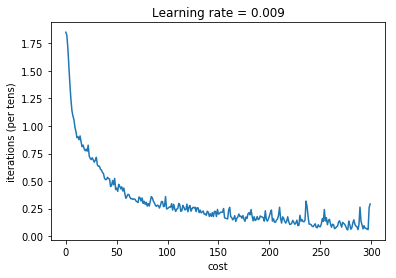

Tensor("Mean_1:0", shape=(), dtype=float32)
Train accuracy  0.9453704
Test accuracy  0.80833334


In [48]:
_, _, parameters = model(X_train, Y_train, X_test, Y_test)